In [1]:
import os

total_cpus = os.cpu_count()  # Get the total number of CPUs
usable_cpus = max(total_cpus - 4, 1)  # Leave at least 1 CPU for PySpark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, lit, col,radians, sin, cos, atan2, sqrt, dayofweek, hour, minute
from pyspark.sql import functions as F

In [3]:
# Configure Spark session
spark = SparkSession.builder \
    .master("local[10]") \
    .appName("NoBroadcastApp") \
    .config("spark.driver.memory", "30g") \
    .config("spark.executor.memory", "30g") \
    .config("spark.executor.cores", "10") \
    .config("spark.sql.shuffle.partitions", "500") \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.broadcast.compress", "false")  \
    .config("spark.broadcast.blockSize", "4m")  \
    .getOrCreate()
# .config("spark.executor.instances", "1") \


25/01/27 12:34:51 WARN Utils: Your hostname, Macbooks-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.18.66 instead (on interface en0)
25/01/27 12:34:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/27 12:34:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Load Dataset
file_path = "data/amazon_delivery.csv"
data = spark.read.csv(file_path, header=True, inferSchema=True).coalesce(1)
data.cache()


DataFrame[Order_ID: string, Agent_Age: int, Agent_Rating: double, Store_Latitude: double, Store_Longitude: double, Drop_Latitude: double, Drop_Longitude: double, Order_Date: date, Order_Time: string, Pickup_Time: timestamp, Weather: string, Traffic: string, Vehicle: string, Area: string, Delivery_Time: int, Category: string]

In [5]:
# Display initial data schema and a few rows
print("Initial Data Schema:")
data.printSchema()

print("Sample Rows:")
data.show(5)

Initial Data Schema:
root
 |-- Order_ID: string (nullable = true)
 |-- Agent_Age: integer (nullable = true)
 |-- Agent_Rating: double (nullable = true)
 |-- Store_Latitude: double (nullable = true)
 |-- Store_Longitude: double (nullable = true)
 |-- Drop_Latitude: double (nullable = true)
 |-- Drop_Longitude: double (nullable = true)
 |-- Order_Date: date (nullable = true)
 |-- Order_Time: string (nullable = true)
 |-- Pickup_Time: timestamp (nullable = true)
 |-- Weather: string (nullable = true)
 |-- Traffic: string (nullable = true)
 |-- Vehicle: string (nullable = true)
 |-- Area: string (nullable = true)
 |-- Delivery_Time: integer (nullable = true)
 |-- Category: string (nullable = true)

Sample Rows:


+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Traffic|    Vehicle|          Area|Delivery_Time|   Category|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|ialx566343618|       37|         4.9|     22.745049|      75.892471|    22.765049|     75.912471|2022-03-19|  11:30:00|2025-01-27 11:45:00|     Sunny|  High |motorcycle |        Urban |          120|   Clothing|
|akqg208421122|       34|         4.5|     12.913041|      77.683237|    13.043041|     77.813237|2022-03-25|  19:45:00|2025-01-27 19:50:00|    Stor

In [6]:
# Separate numerical and non-numerical columns
numerical_cols = ["Agent_Age", "Agent_Rating", "Store_Latitude", "Store_Longitude", 
                  "Drop_Latitude", "Drop_Longitude", "Delivery_Time"]
non_numerical_cols = ["Order_ID", "Order_Date", "Order_Time", "Pickup_Time", 
                      "Weather", "Traffic", "Vehicle", "Area", "Category"]

# Check missing data for numerical columns (NULL, NaN, or Zero)
numerical_missing = [
    count(when(col(c).isNull() | isnan(col(c)) | (col(c) == 0), c)).alias(c) 
    for c in numerical_cols
]

# Check missing data for non-numerical columns (only NULL)
non_numerical_missing = [count(when(col(c).isNull(), c)).alias(c) for c in non_numerical_cols]

# Combine both checks
missing_data = data.select(numerical_missing + non_numerical_missing)

# Show missing data per column
print("Missing Data Per Column (Including Zero Values for Numerical):")
missing_data.show()

Missing Data Per Column (Including Zero Values for Numerical):
+---------+------------+--------------+---------------+-------------+--------------+-------------+--------+----------+----------+-----------+-------+-------+-------+----+--------+
|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Delivery_Time|Order_ID|Order_Date|Order_Time|Pickup_Time|Weather|Traffic|Vehicle|Area|Category|
+---------+------------+--------------+---------------+-------------+--------------+-------------+--------+----------+----------+-----------+-------+-------+-------+----+--------+
|        0|          54|          3505|           3505|            0|             0|            0|       0|         0|         0|          0|      0|      0|      0|   0|       0|
+---------+------------+--------------+---------------+-------------+--------------+-------------+--------+----------+----------+-----------+-------+-------+-------+----+--------+



In [7]:
# Drop rows with missing Store_Latitude or Store_Longitude
data = data.filter(
    (col("Store_Latitude") != 0) & 
    (col("Store_Longitude") != 0) &
    (col("Store_Latitude").isNotNull()) & 
    (col("Store_Longitude").isNotNull())
)

# Impute missing Agent_Rating with mean (optional)
mean_rating = data.selectExpr("avg(Agent_Rating)").collect()[0][0]
data = data.fillna({"Agent_Rating": mean_rating})

# Show the cleaned dataset and updated row count
print("Cleaned Data After Handling Missing Values:")
data.show(5)
print(f"Rows after cleaning: {data.count()}")

Cleaned Data After Handling Missing Values:
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Traffic|    Vehicle|          Area|Delivery_Time|   Category|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|ialx566343618|       37|         4.9|     22.745049|      75.892471|    22.765049|     75.912471|2022-03-19|  11:30:00|2025-01-27 11:45:00|     Sunny|  High |motorcycle |        Urban |          120|   Clothing|
|akqg208421122|       34|         4.5|     12.913041|      77.683237|    13.043041|     77.813237|2022-0

In [8]:
data.select(numerical_cols).describe().show()

25/01/27 12:35:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|         Agent_Age|       Agent_Rating|    Store_Latitude|  Store_Longitude|     Drop_Latitude|    Drop_Longitude|     Delivery_Time|
+-------+------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|             40234|              40234|             40234|            40234|             40234|             40234|             40234|
|   mean|29.563329522294577|  4.632386165712845|18.710299094796312|76.81685140127617|18.974482011607027| 76.98601405545092|125.06362777750162|
| stddev| 5.812360905264559|0.33535734399977923|  6.12218385061891|5.336761441558472| 5.473219684071353|3.5012911185670625|51.902666475685834|
|    min|                15|                1.0|        -30.902872|       -88.366217|          9.967144|         72.778726|                10|

In [9]:
# Value counts for categorical columns
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
for col_name in categorical_cols:
    print(f"Value Counts for {col_name}:")
    data.groupBy(col_name).count().show()


Value Counts for Weather:
+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6809|
|     Windy| 6649|
|       NaN|   81|
+----------+-----+

Value Counts for Traffic:
+-------+-----+
|Traffic|count|
+-------+-----+
|  High | 3950|
|   Jam |12657|
|   Low |13758|
|Medium | 9788|
|   NaN |   81|
+-------+-----+

Value Counts for Vehicle:
+-----------+-----+
|    Vehicle|count|
+-----------+-----+
|motorcycle |23563|
|   scooter |13431|
|        van| 3228|
|   bicycle |   12|
+-----------+-----+

Value Counts for Area:
+--------------+-----+
|          Area|count|
+--------------+-----+
|        Urban | 8924|
|Metropolitian |30119|
|         Other| 1053|
|   Semi-Urban |  138|
+--------------+-----+

Value Counts for Category:
+------------+-----+
|    Category|count|
+------------+-----+
|    Clothing| 2437|
| Electronics| 2626|
|      Sports| 2489|
|   Cosmetics| 2462|
|        Toys| 2577|
|  

In [10]:
# Replace "NaN" strings with NULL in relevant columns
data = data.withColumn("Weather", when(col("Weather") == "NaN", None).otherwise(col("Weather")))
data = data.withColumn("Traffic", when(col("Traffic") == "NaN ", None).otherwise(col("Traffic")))

# Confirm the replacements
print("Updated Value Counts for Weather:")
data.groupBy("Weather").count().show()

print("Updated Value Counts for Traffic:")
data.groupBy("Traffic").count().show()

Updated Value Counts for Weather:
+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6809|
|     Windy| 6649|
|      NULL|   81|
+----------+-----+

Updated Value Counts for Traffic:
+-------+-----+
|Traffic|count|
+-------+-----+
|  High | 3950|
|   Jam |12657|
|   Low |13758|
|Medium | 9788|
|   NULL|   81|
+-------+-----+



In [11]:
# Replace NULL in Weather with the most frequent value (mode)
most_frequent_weather = data.groupBy("Weather").count().orderBy(col("count").desc()).first()["Weather"]
data = data.fillna({"Weather": most_frequent_weather})

# Replace "NaN" in Traffic with the most frequent value or a new category
most_frequent_traffic = data.groupBy("Traffic").count().orderBy(col("count").desc()).first()["Traffic"]
data = data.fillna({"Traffic": most_frequent_traffic})

# Confirm updates
print("Value Counts for Weather After Imputation:")
data.groupBy("Weather").count().show()

print("Value Counts for Traffic After Imputation:")
data.groupBy("Traffic").count().show()


Value Counts for Weather After Imputation:
+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6890|
|     Windy| 6649|
+----------+-----+

Value Counts for Traffic After Imputation:
+-------+-----+
|Traffic|count|
+-------+-----+
|  High | 3950|
|   Jam |12657|
|   Low |13839|
|Medium | 9788|
+-------+-----+



In [12]:
# Check for duplicates
total_rows = data.count()
distinct_rows = data.distinct().count()
print(f"Total Rows: {total_rows}, Distinct Rows: {distinct_rows}")

if total_rows > distinct_rows:
    print(f"Duplicate Rows: {total_rows - distinct_rows}")
    # Remove duplicates
    data = data.dropDuplicates()

Total Rows: 40234, Distinct Rows: 40234


In [13]:
# Check if Order_Time is earlier than Pickup_Time
invalid_order_pickup = data.filter(col("Order_Time") > col("Pickup_Time"))
print(f"Rows with Invalid Order and Pickup Times: {invalid_order_pickup.count()}")
invalid_order_pickup.show()

# Check if Delivery_Time is positive and within a reasonable range
invalid_delivery_time = data.filter(col("Delivery_Time") <= 0)
print(f"Rows with Invalid Delivery Time: {invalid_delivery_time.count()}")
invalid_delivery_time.show()


Rows with Invalid Order and Pickup Times: 759
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Traffic|    Vehicle|          Area|Delivery_Time|   Category|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+
|wycd588946822|       26|         4.7|     17.431477|       78.40035|    17.491477|      78.46035|2022-03-05|  23:50:00|2025-01-27 00:05:00|       Fog|   Low |motorcycle |Metropolitian |           50|      Shoes|
|okvp821614347|       25|         4.8|     17.458998|      78.500366|    17.488998|     78.530366|2022

In [14]:
# Check for invalid coordinates
invalid_coords = data.filter(
    (col("Store_Latitude") < -90) | (col("Store_Latitude") > 90) |
    (col("Store_Longitude") < -180) | (col("Store_Longitude") > 180) |
    (col("Drop_Latitude") < -90) | (col("Drop_Latitude") > 90) |
    (col("Drop_Longitude") < -180) | (col("Drop_Longitude") > 180)
)
print(f"Rows with Invalid Coordinates: {invalid_coords.count()}")
invalid_coords.show()


Rows with Invalid Coordinates: 0
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+--------+
|Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|Pickup_Time|Weather|Traffic|Vehicle|Area|Delivery_Time|Category|
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+--------+
+--------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-----------+-------+-------+-------+----+-------------+--------+



In [15]:
from pyspark.sql.functions import col, radians, sin, cos, sqrt, atan2

# Earth's radius in kilometers
R = 6371.0

def calculate_haversine_distance(store_lat_col, store_long_col, drop_lat_col, drop_long_col):
    """
    Calculate the Haversine distance between two points on Earth.
    
    Args:
        store_lat_col: Column for store latitude
        store_long_col: Column for store longitude
        drop_lat_col: Column for drop latitude
        drop_long_col: Column for drop longitude
    
    Returns:
        A column expression for the calculated distance in kilometers.
    """
    return 2 * R * atan2(
        sqrt(
            sin((radians(drop_lat_col) - radians(store_lat_col)) / 2) ** 2 +
            cos(radians(store_lat_col)) * cos(radians(drop_lat_col)) *
            sin((radians(drop_long_col) - radians(store_long_col)) / 2) ** 2
        ),
        sqrt(
            1 - (
                sin((radians(drop_lat_col) - radians(store_lat_col)) / 2) ** 2 +
                cos(radians(store_lat_col)) * cos(radians(drop_lat_col)) *
                sin((radians(drop_long_col) - radians(store_long_col)) / 2) ** 2
            )
        )
    )

# Example Usage
data = data.withColumn(
    "Distance",
    calculate_haversine_distance(
        col("Store_Latitude"), col("Store_Longitude"),
        col("Drop_Latitude"), col("Drop_Longitude")
    )
)

# Show sample rows with calculated distance
print("Sample Rows with Distance Calculated:")
data.select("Store_Latitude", "Store_Longitude", "Drop_Latitude", "Drop_Longitude", "Distance").show(5)


Sample Rows with Distance Calculated:
+--------------+---------------+-------------+--------------+------------------+
|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|          Distance|
+--------------+---------------+-------------+--------------+------------------+
|     22.745049|      75.892471|    22.765049|     75.912471|3.0251492856772435|
|     12.913041|      77.683237|    13.043041|     77.813237| 20.18352972873253|
|     12.914264|        77.6784|    12.924264|       77.6884| 1.552757802254999|
|     11.003669|      76.976494|    11.053669|     77.026494| 7.790401360105878|
|     12.972793|      80.249982|    13.012793|     80.289982|6.2101379656242255|
+--------------+---------------+-------------+--------------+------------------+
only showing top 5 rows



In [16]:
# Extract Day of the Week (1 = Sunday, 7 = Saturday)
data = data.withColumn("Day_of_Week", dayofweek(col("Order_Date")))

# Extract Hour from Order Time
data = data.withColumn("Order_Hour", hour(col("Order_Time")))

# Extract Minute from Order Time
data = data.withColumn("Order_Minute", minute(col("Order_Time")))

# Extract Hour from Order Time
data = data.withColumn("Pickup_Hour", hour(col("Pickup_Time")))

# Extract Minute from Order Time
data = data.withColumn("Pickup_Minute", minute(col("Pickup_Time")))

In [17]:
data.show(5)

+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+------------------+-----------+----------+------------+-----------+-------------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Traffic|    Vehicle|          Area|Delivery_Time|   Category|          Distance|Day_of_Week|Order_Hour|Order_Minute|Pickup_Hour|Pickup_Minute|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------+-----------+--------------+-------------+-----------+------------------+-----------+----------+------------+-----------+-------------+
|ialx566343618|       37|         4.9|     22.745049|      75.892471|    22.765049|     75.912471|2022-03-19|  11:30:0

In [18]:
# data = data.withColumn("Day_Sin", sin(2 * 3.1416 * col("Day_of_Week") / 7))
# data = data.withColumn("Day_Cos", cos(2 * 3.1416 * col("Day_of_Week") / 7))

# data = data.withColumn("Order_Hour_Sin", sin(2 * 3.1416 * col("Order_Hour") / 24))
# data = data.withColumn("Order_Hour_Cos", cos(2 * 3.1416 * col("Order_Hour") / 24))
# data = data.withColumn("Order_Minute_sin", sin(2 * 3.14159 * col("Order_Minute") / 60))
# data = data.withColumn("Order_Minute_cos", cos(2 * 3.14159 * col("Order_Minute") / 60))

# data = data.withColumn("Pickup_Hour_Sin", sin(2 * 3.1416 * col("Pickup_Hour") / 24))
# data = data.withColumn("Pickup_Hour_Cos", cos(2 * 3.1416 * col("Pickup_Hour") / 24))
# data = data.withColumn("Pickup_Minute_sin", sin(2 * 3.14159 * col("Pickup_Minute") / 60))
# data = data.withColumn("Pickup_Minute_cos", cos(2 * 3.14159 * col("Pickup_Minute") / 60))

In [19]:
# Function to remove leading and trailing whitespaces
def clean_whitespace(df, column_name):
    return df.withColumn(column_name, F.trim(df[column_name]))

# Clean all categorical columns
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]

for col_name in categorical_cols:
    data = clean_whitespace(data, col_name)

# Now check the value counts after cleaning
for col_name in categorical_cols:
    print(f"Value Counts for {col_name}:")
    data.groupBy(col_name).count().show()

Value Counts for Weather:
+----------+-----+
|   Weather|count|
+----------+-----+
|     Sunny| 6534|
|    Stormy| 6779|
|Sandstorms| 6682|
|    Cloudy| 6700|
|       Fog| 6890|
|     Windy| 6649|
+----------+-----+

Value Counts for Traffic:
+-------+-----+
|Traffic|count|
+-------+-----+
|   High| 3950|
|    Jam|12657|
|    Low|13839|
| Medium| 9788|
+-------+-----+

Value Counts for Vehicle:
+----------+-----+
|   Vehicle|count|
+----------+-----+
|motorcycle|23563|
|   scooter|13431|
|       van| 3228|
|   bicycle|   12|
+----------+-----+

Value Counts for Area:
+-------------+-----+
|         Area|count|
+-------------+-----+
|        Urban| 8924|
|Metropolitian|30119|
|        Other| 1053|
|   Semi-Urban|  138|
+-------------+-----+

Value Counts for Category:
+------------+-----+
|    Category|count|
+------------+-----+
|    Clothing| 2437|
| Electronics| 2626|
|      Sports| 2489|
|   Cosmetics| 2462|
|        Toys| 2577|
|      Snacks| 2524|
|       Shoes| 2455|
|     Appare

In [20]:
# Function to remove leading and trailing whitespaces
def clean_whitespace(df, column_name):
    return df.withColumn(column_name, F.trim(df[column_name]))

# Clean all categorical columns
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]

for col_name in categorical_cols:
    data = clean_whitespace(data, col_name)

In [21]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd


# Function to balance classes
def balance_classes(data, col_name, method="oversample"):
    # Convert Spark DataFrame to Pandas DataFrame for imbalanced-learn
    pandas_df = data.toPandas()

    if method == "oversample":
        # Apply oversampling using RandomOverSampler
        ros = RandomOverSampler(sampling_strategy='auto')
        X = pandas_df.drop(columns=[col_name])
        y = pandas_df[col_name]
        X_res, y_res = ros.fit_resample(X, y)
        resampled_df = pd.concat([X_res, y_res], axis=1)
        # Convert back to Spark DataFrame
        balanced_data = spark.createDataFrame(resampled_df)
        return balanced_data
    elif method == "undersample":
        # Apply undersampling using RandomUnderSampler
        rus = RandomUnderSampler(sampling_strategy='auto')
        X = pandas_df.drop(columns=[col_name])
        y = pandas_df[col_name]
        X_res, y_res = rus.fit_resample(X, y)
        resampled_df = pd.concat([X_res, y_res], axis=1)
        # Convert back to Spark DataFrame
        balanced_data = spark.createDataFrame(resampled_df)
        return balanced_data
    else:
        raise ValueError("Invalid method. Choose 'oversample' or 'undersample'.")


In [22]:
# Handling each categorical column one by one

# 1. Weather
# No imbalance in Weather, so no action is required.


In [23]:
# 2. Traffic
# Oversample the minority categories (High and Medium)
data = balance_classes(data, "Traffic", method="oversample")



In [24]:
# 3. Vehicle
# Combine bicycle with motorcycle
data = data.withColumn(
    "Vehicle",
    F.when(data["Vehicle"] == "bicycle", "motorcycle").otherwise(data["Vehicle"])
)

# Oversample the van category if needed
data = balance_classes(data, "Vehicle", method="oversample")



25/01/27 12:35:25 WARN TaskSetManager: Stage 36 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


In [25]:
# 4. Area
# Combine Semi-Urban with Other
data = data.withColumn(
    "Area",
    F.when(data["Area"] == "Semi-Urban", "Other").otherwise(data["Area"])
)

# Oversample the 'Other' category
data = balance_classes(data, "Area", method="oversample")


25/01/27 12:35:35 WARN TaskSetManager: Stage 37 contains a task of very large size (1586 KiB). The maximum recommended task size is 1000 KiB.


In [26]:
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
for col_name in categorical_cols:
    print(f"Value Counts for {col_name}:")
    data.groupBy(col_name).count().show()


Value Counts for Weather:


25/01/27 12:35:54 WARN TaskSetManager: Stage 38 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|   Weather|count|
+----------+-----+
|     Windy|37781|
|       Fog|34436|
|Sandstorms|36603|
|    Cloudy|36114|
|     Sunny|38657|
|    Stormy|35217|
+----------+-----+

Value Counts for Traffic:


25/01/27 12:35:57 WARN TaskSetManager: Stage 41 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+-------+-----+
|Traffic|count|
+-------+-----+
| Medium|52454|
|    Jam|52796|
|   High|52418|
|    Low|61140|
+-------+-----+

Value Counts for Vehicle:


25/01/27 12:35:58 WARN TaskSetManager: Stage 44 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+----------+-----+
|   Vehicle|count|
+----------+-----+
|       van|69997|
|   scooter|76193|
|motorcycle|72618|
+----------+-----+

Value Counts for Area:


25/01/27 12:35:59 WARN TaskSetManager: Stage 47 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+-------------+-----+
|         Area|count|
+-------------+-----+
|        Urban|72936|
|        Other|72936|
|Metropolitian|72936|
+-------------+-----+

Value Counts for Category:


25/01/27 12:36:00 WARN TaskSetManager: Stage 50 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


+------------+-----+
|    Category|count|
+------------+-----+
|     Kitchen|13488|
|      Sports|13622|
|     Grocery|13843|
|    Outdoors|12658|
|      Snacks|13703|
|       Books|14508|
|   Cosmetics|14230|
|    Skincare|14148|
|       Shoes|12509|
|     Jewelry|13638|
|     Apparel|13988|
|        Toys|13931|
| Electronics|14664|
|        Home|13918|
|Pet Supplies|12630|
|    Clothing|13330|
+------------+-----+



25/01/27 12:36:01 WARN TaskSetManager: Stage 53 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


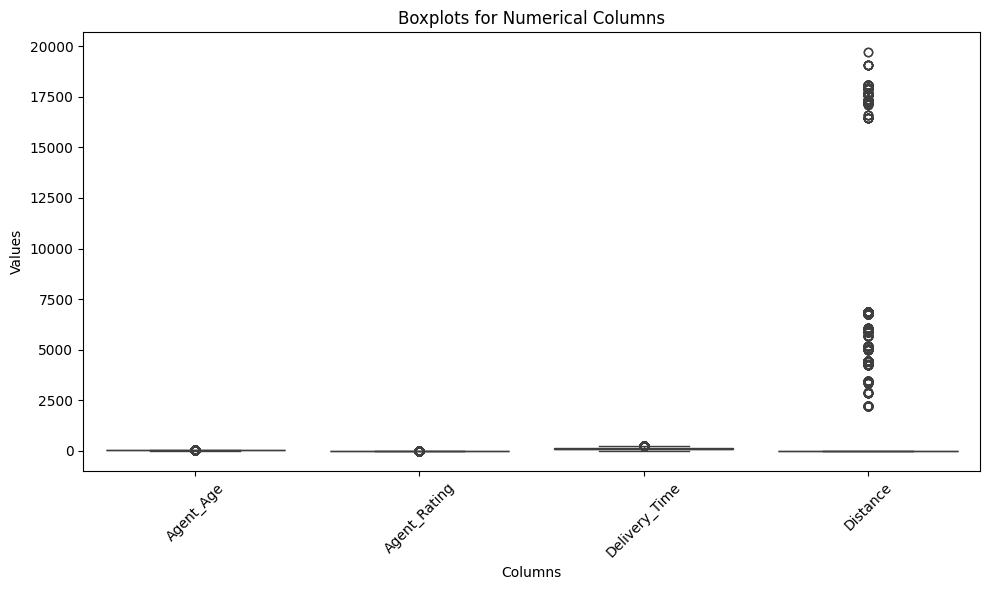

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

def draw_combined_boxplot(data, columns):
    # Select the numerical columns and convert to Pandas
    pandas_df = data.select(*columns).toPandas()
    
    # Melt the DataFrame to a long format suitable for Seaborn
    melted_df = pandas_df.melt(var_name="Variable", value_name="Value")
    
    # Plot the combined boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=melted_df, x="Variable", y="Value")
    plt.title("Boxplots for Numerical Columns")
    plt.xlabel("Columns")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Numerical columns to visualize
numerical_cols = ["Agent_Age", "Agent_Rating", "Delivery_Time", "Distance"]

# Draw the combined boxplot
draw_combined_boxplot(data, numerical_cols)


In [28]:
# Save the original dataset before outlier handling
output_path_before = "amazon_delivery_before_outlier_handling.csv"  # Replace with your desired path
data.coalesce(1).write.csv(output_path_before, header=True,mode="overwrite")
print(f"Dataset saved before outlier handling at: {output_path_before}")


25/01/27 12:36:03 WARN TaskSetManager: Stage 54 contains a task of very large size (35928 KiB). The maximum recommended task size is 1000 KiB.


Dataset saved before outlier handling at: amazon_delivery_before_outlier_handling.csv


In [29]:
from pyspark.sql.functions import col

def remove_outliers(data, column):
    # Calculate the IQR and bounds
    quantiles = data.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data to remove rows with outliers
    filtered_data = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    print(f"Rows remaining after removing outliers in {column}: {filtered_data.count()}")
    return filtered_data

# Apply outlier removal to all numerical columns
for col_name in numerical_cols:
    data = remove_outliers(data, col_name)

# Show the resulting dataset
data.show(5)

25/01/27 12:36:06 WARN TaskSetManager: Stage 55 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:07 WARN TaskSetManager: Stage 57 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Rows remaining after removing outliers in Agent_Age: 218175


25/01/27 12:36:08 WARN TaskSetManager: Stage 60 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:08 WARN TaskSetManager: Stage 62 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Rows remaining after removing outliers in Agent_Rating: 197338


25/01/27 12:36:09 WARN TaskSetManager: Stage 65 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:09 WARN TaskSetManager: Stage 67 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Rows remaining after removing outliers in Delivery_Time: 191685


25/01/27 12:36:10 WARN TaskSetManager: Stage 70 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:10 WARN TaskSetManager: Stage 72 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


Rows remaining after removing outliers in Distance: 188796
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------------+-----------+------------------+-----------+----------+------------+-----------+-------------+-------+----------+-------------+
|     Order_ID|Agent_Age|Agent_Rating|Store_Latitude|Store_Longitude|Drop_Latitude|Drop_Longitude|Order_Date|Order_Time|        Pickup_Time|   Weather|Delivery_Time|   Category|          Distance|Day_of_Week|Order_Hour|Order_Minute|Pickup_Hour|Pickup_Minute|Traffic|   Vehicle|         Area|
+-------------+---------+------------+--------------+---------------+-------------+--------------+----------+----------+-------------------+----------+-------------+-----------+------------------+-----------+----------+------------+-----------+-------------+-------+----------+-------------+
|ialx566343618|       37|         4.9|     22.745049|      75.892

25/01/27 12:36:10 WARN TaskSetManager: Stage 75 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


25/01/27 12:36:11 WARN TaskSetManager: Stage 76 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.


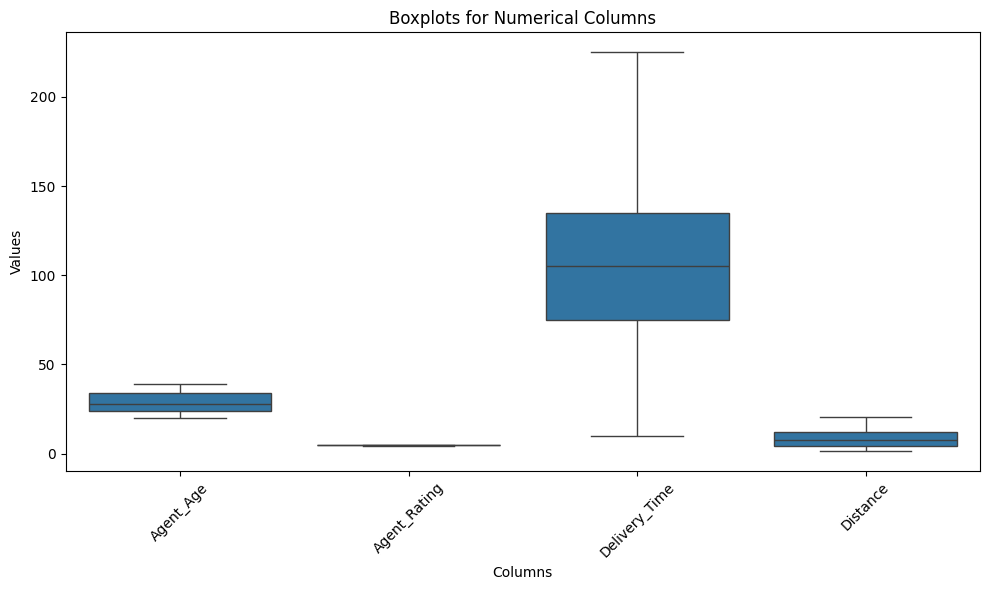

In [30]:
# Draw the combined boxplot
draw_combined_boxplot(data, numerical_cols)

In [31]:
# Save the dataset after flagging outliers
output_path_after = "cleaned_data.csv"  # Replace with your desired path
data.coalesce(1).write.csv(output_path_after, header=True,mode="overwrite")
print(f"Dataset saved after retaining outliers at: {output_path_after}")


25/01/27 12:36:13 WARN TaskSetManager: Stage 77 contains a task of very large size (35928 KiB). The maximum recommended task size is 1000 KiB.


Dataset saved after retaining outliers at: cleaned_data.csv


In [32]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.stat import Correlation, ChiSquareTest

25/01/27 12:36:15 WARN TaskSetManager: Stage 78 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:15 WARN TaskSetManager: Stage 79 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:16 WARN TaskSetManager: Stage 81 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:16 WARN TaskSetManager: Stage 82 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:18 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


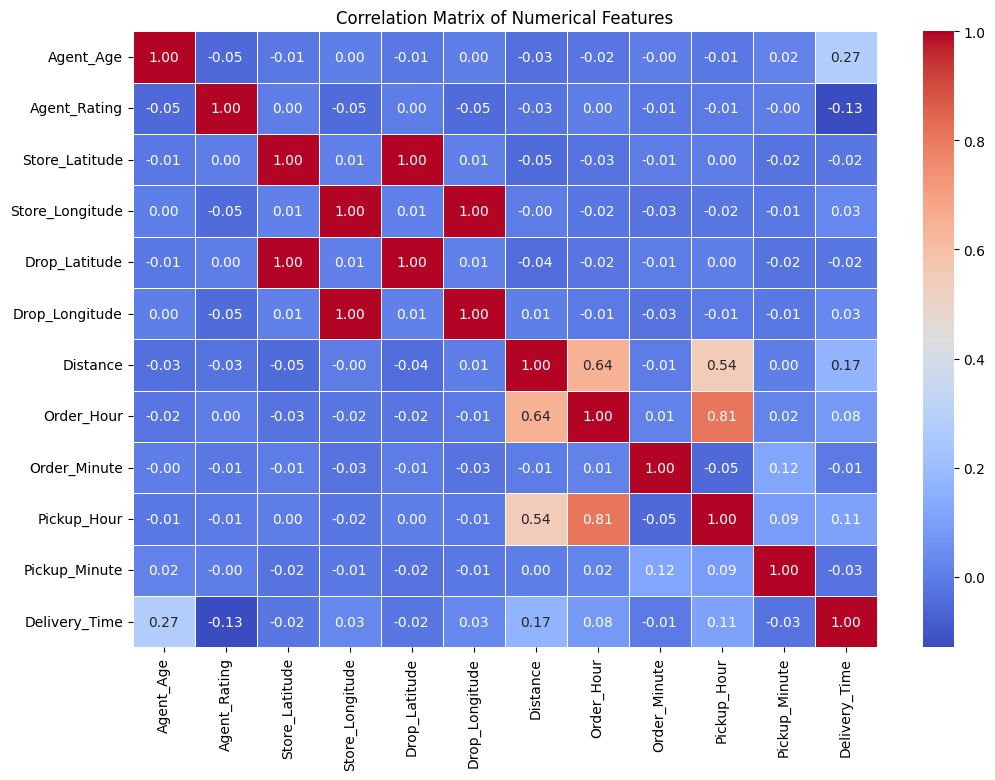

In [33]:
numerical_cols = ['Agent_Age', 'Agent_Rating', 'Store_Latitude', 
                  'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Distance', "Order_Hour","Order_Minute","Pickup_Hour","Pickup_Minute", 'Delivery_Time']
# Assemble numerical columns into a single vector
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
vector_data = assembler.transform(data).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(vector_data, "features").head()[0].toArray()

# # Convert correlation matrix to Pandas DataFrame for better readability
import pandas as pd
correlation_df = pd.DataFrame(
    correlation_matrix, 
    columns=numerical_cols, 
    index=numerical_cols
)

# # Display the correlation matrix
# print("Correlation Matrix for Numerical Features:")
# print(correlation_df)


# Compute the correlation matrix for the numerical columns
# correlation_matrix = data.select(numerical_cols).toPandas().corr()

# Plot the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


In [34]:
from pyspark.sql.functions import mean, col, count
from scipy.stats import f

def anova_all(df, categorical_cols, target_col):
    # Overall mean of the target column
    overall_mean = df.select(mean(target_col)).first()[0]
    results = {}
    for categorical_col in categorical_cols:
        # Group statistics by the categorical column
        grouped_stats = df.groupBy(categorical_col).agg(
            mean(target_col).alias('group_mean'),
            count(target_col).alias('group_count')
        )
        # Calculate Between-Group Sum of Squares (SSB)
        ssb = grouped_stats.withColumn(
            'ssb',
            (col('group_mean') - overall_mean) ** 2 * col('group_count')
        ).agg({'ssb': 'sum'}).first()[0]
        # Calculate Within-Group Sum of Squares (SSW)
        ssw = df.join(grouped_stats, on=categorical_col).withColumn(
            'ssw',
            (col(target_col) - col('group_mean')) ** 2
        ).agg({'ssw': 'sum'}).first()[0]
        # Degrees of freedom
        df_between = grouped_stats.count() - 1  # Number of groups - 1
        df_within = df.count() - grouped_stats.count()  # Total samples - number of groups
        # Calculate F-statistic
        ms_between = ssb / df_between if df_between != 0 else 0
        ms_within = ssw / df_within if df_within != 0 else 0
        f_statistic = ms_between / ms_within if ms_within != 0 else 0
        # Calculate p-value using scipy
        p_value = 1 - f.cdf(f_statistic, df_between, df_within) if df_within > 0 else 1
        # Store results
        results[categorical_col] = {
            'F-Statistic': f_statistic,
            'p-value': p_value,
            'df_between': df_between,
            'df_within': df_within
        }
    return results


# List of categorical columns and target column
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]
target_col = "Delivery_Time"

# Perform ANOVA
anova_results = anova_all(data, categorical_cols, target_col)

# Display results
print("ANOVA Results:")
for feature, stats in anova_results.items():
    print(f"Feature: {feature}")
    print(f"  F-Statistic: {stats['F-Statistic']:.2f}")
    print(f"  p-value: {stats['p-value']:.14f}")
    print(f"  Degrees of Freedom (Between): {stats['df_between']}")
    print(f"  Degrees of Freedom (Within): {stats['df_within']}")
    print("\n")


25/01/27 12:36:19 WARN TaskSetManager: Stage 84 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:19 WARN TaskSetManager: Stage 87 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:20 WARN TaskSetManager: Stage 93 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:21 WARN TaskSetManager: Stage 94 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:23 WARN TaskSetManager: Stage 102 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:24 WARN TaskSetManager: Stage 108 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:24 WARN TaskSetManager: Stage 111 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/

ANOVA Results:
Feature: Weather
  F-Statistic: 2666.09
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 5
  Degrees of Freedom (Within): 188790


Feature: Traffic
  F-Statistic: 5073.94
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 3
  Degrees of Freedom (Within): 188792


Feature: Vehicle
  F-Statistic: 1645.39
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 2
  Degrees of Freedom (Within): 188793


Feature: Area
  F-Statistic: 3863.55
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 2
  Degrees of Freedom (Within): 188793


Feature: Category
  F-Statistic: 4415.17
  p-value: 0.00000000000000
  Degrees of Freedom (Between): 15
  Degrees of Freedom (Within): 188780




In [35]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Step 1: Define columns
numerical_cols = ['Agent_Age', 'Agent_Rating', 'Distance', 'Pickup_Hour']
categorical_cols = ["Weather", "Traffic", "Vehicle", "Area", "Category"]

# Step 2: Index categorical columns (convert strings to numbers)
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_Indexed") for col in categorical_cols]

# Step 3: One-hot encode categorical features (transform indexed labels to one-hot encoding)
encoders = [OneHotEncoder(inputCol=f"{col}_Indexed", outputCol=f"{col}_OneHot") for col in categorical_cols]

# Step 4: Assemble numerical and categorical features into a single vector
assembler = VectorAssembler(inputCols=numerical_cols + [f"{col}_OneHot" for col in categorical_cols], outputCol="features")

# Step 5: Apply transformations to the data (indexing, encoding, assembling)
pipeline_steps = indexers + encoders + [assembler]
pipeline = Pipeline(stages=pipeline_steps)
data_transformed = pipeline.fit(data).transform(data)

# Step 6: Split the data into training and test sets
train_data, test_data = data_transformed.randomSplit([0.8, 0.2], seed=42)

# Step 7: Scale numerical features for Linear Regression (only)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
train_data_scaled = scaler.fit(train_data).transform(train_data)
test_data_scaled = scaler.fit(test_data).transform(test_data)

results=[]

25/01/27 12:36:38 WARN TaskSetManager: Stage 237 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:40 WARN TaskSetManager: Stage 240 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:41 WARN TaskSetManager: Stage 243 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:42 WARN TaskSetManager: Stage 246 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:42 WARN TaskSetManager: Stage 249 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:44 WARN TaskSetManager: Stage 252 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 12:36:47 WARN TaskSetManager: Stage 255 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.

In [36]:
# Step 8: Cross-Validation setup for Linear Regression with scaled features
lr = LinearRegression(featuresCol="scaled_features", labelCol="Delivery_Time")

# Define hyperparameter grid for Linear Regression
param_grid_lr = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()


# Setup evaluator and cross-validation
evaluator = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="rmse")
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=param_grid_lr, evaluator=evaluator, numFolds=5)

# Fit Linear Regression with Cross-Validation
cv_model_lr = cv_lr.fit(train_data_scaled)

# Best model for Linear Regression
best_model_lr = cv_model_lr.bestModel

# Step 9: Predict and evaluate on test data for Linear Regression
predictions_lr = best_model_lr.transform(test_data_scaled)
rmse_lr = evaluator.evaluate(predictions_lr)
mae_lr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_lr)
r2_lr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_lr)

print("Linear Regression Performance (CV):")
print(f"RMSE: {rmse_lr:.3f}")
print(f"MAE: {mae_lr:.3f}")
print(f"R²: {r2_lr:.3f}")
results.append(("Linear Regression", rmse_lr, mae_lr, r2_lr))

25/01/27 13:05:41 WARN TaskSetManager: Stage 258 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:05:48 WARN TaskSetManager: Stage 259 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:05:49 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
25/01/27 13:05:50 WARN TaskSetManager: Stage 261 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:05:51 WARN TaskSetManager: Stage 263 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:05:52 WARN TaskSetManager: Stage 264 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:05:53 WARN TaskSetManager: Stage 266 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:05:53 WARN TaskSetM

Linear Regression Performance (CV):
RMSE: 29.180
MAE: 23.271
R²: 0.550


In [37]:
from pyspark.ml.regression import GBTRegressor

# Step 10: Cross-Validation setup for Gradient-Boosted Trees (GBT)
gbt = GBTRegressor(featuresCol="features", labelCol="Delivery_Time", maxIter=100, seed=42, validationTol=0.01)

param_grid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [10, 50, 100]) \
    .addGrid(gbt.stepSize, [0.01, 0.1, 0.3]) \
    .build()


# Setup cross-validation for GBT
cv_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=param_grid_gbt, evaluator=evaluator, numFolds=5)

# Fit GBT with Cross-Validation
cv_model_gbt = cv_gbt.fit(train_data)

# Best model for GBT
best_model_gbt = cv_model_gbt.bestModel

# Step 11: Predict and evaluate on test data for GBT
predictions_gbt = best_model_gbt.transform(test_data)
rmse_gbt = evaluator.evaluate(predictions_gbt)
mae_gbt = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_gbt)
r2_gbt = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_gbt)

print("GBT Performance (CV):")
print(f"RMSE: {rmse_gbt:.3f}")
print(f"MAE: {mae_gbt:.3f}")
print(f"R²: {r2_gbt:.3f}")
results.append(("GBT", rmse_gbt, mae_gbt, r2_gbt))

25/01/27 13:06:57 WARN TaskSetManager: Stage 548 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:06:59 WARN TaskSetManager: Stage 549 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:06:59 WARN TaskSetManager: Stage 550 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:06:59 WARN TaskSetManager: Stage 551 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:07:00 WARN TaskSetManager: Stage 553 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:07:01 WARN TaskSetManager: Stage 555 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 13:07:01 WARN TaskSetManager: Stage 557 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.

GBT Performance (CV):
RMSE: 11.495
MAE: 6.591
R²: 0.930


In [38]:
from pyspark.ml.regression import DecisionTreeRegressor

# Step 10: Cross-Validation setup for Decision Tree Regressor (DTR)
dtr = DecisionTreeRegressor(featuresCol="features", labelCol="Delivery_Time")

# Define hyperparameter grid for DTR
param_grid_dtr = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [5, 10, 20]) \
    .addGrid(dtr.minInstancesPerNode, [1, 5, 10]) \
    .build()

# Setup cross-validation for DTR
cv_dtr = CrossValidator(estimator=dtr, estimatorParamMaps=param_grid_dtr, evaluator=evaluator, numFolds=5)

# Fit DTR with Cross-Validation
cv_model_dtr = cv_dtr.fit(train_data)

# Best model for DTR
best_model_dtr = cv_model_dtr.bestModel

# Step 11: Predict and evaluate on test data for DTR
predictions_dtr = best_model_dtr.transform(test_data)
rmse_dtr = evaluator.evaluate(predictions_dtr)
mae_dtr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_dtr)
r2_dtr = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_dtr)

print("Decision Tree Regressor Performance (CV):")
print(f"RMSE: {rmse_dtr:.3f}")
print(f"MAE: {mae_dtr:.3f}")
print(f"R²: {r2_dtr:.3f}")
results.append(("Decision Tree", rmse_dtr, mae_dtr, r2_dtr))

25/01/27 14:36:01 WARN TaskSetManager: Stage 74778 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 14:36:04 WARN TaskSetManager: Stage 74779 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 14:36:04 WARN TaskSetManager: Stage 74780 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 14:36:05 WARN TaskSetManager: Stage 74781 contains a task of very large size (3690 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 14:36:05 WARN TaskSetManager: Stage 74783 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 14:36:06 WARN TaskSetManager: Stage 74785 contains a task of very large size (3689 KiB). The maximum recommended task size is 1000 KiB.
25/01/27 14:36:06 WARN TaskSetManager: Stage 74787 contains a task of very large size (3689 KiB). The maximum recommended task siz

Decision Tree Regressor Performance (CV):
RMSE: 10.966
MAE: 4.320
R²: 0.937


In [38]:
# Step 10: Cross-Validation setup for Random Forest (without scaling)
rf = RandomForestRegressor(featuresCol="features", labelCol="Delivery_Time")

# Define hyperparameter grid for Random Forest (you can add more parameters to tune)
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()


# Setup cross-validation for Random Forest
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5)

# Fit Random Forest with Cross-Validation
cv_model_rf = cv_rf.fit(train_data)

# Best model for Random Forest
best_model_rf = cv_model_rf.bestModel

# Step 11: Predict and evaluate on test data for Random Forest
predictions_rf = best_model_rf.transform(test_data)
rmse_rf = evaluator.evaluate(predictions_rf)
mae_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(predictions_rf)
r2_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(predictions_rf)

print("Random Forest Performance (CV):")
print(f"RMSE: {rmse_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")
print(f"R²: {r2_rf:.3f}")
results.append(("Random Forest", rmse_rf, mae_rf, r2_rf))

25/01/25 19:26:25 WARN TaskSetManager: Stage 76005 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/25 19:26:28 WARN TaskSetManager: Stage 76006 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/25 19:26:28 WARN TaskSetManager: Stage 76007 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/25 19:26:28 WARN TaskSetManager: Stage 76008 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/25 19:26:28 WARN TaskSetManager: Stage 76010 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/25 19:26:30 WARN TaskSetManager: Stage 76012 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/25 19:26:30 WARN TaskSetManager: Stage 76014 contains a task of very large size (5580 KiB). The maximum recommended task siz

Random Forest Performance (CV):
RMSE: 9.216
MAE: 4.808
R²: 0.956


25/01/26 03:31:32 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 935285 ms exceeds timeout 120000 ms
25/01/26 03:31:32 WARN SparkContext: Killing executors is not supported by current scheduler.
25/01/26 03:31:32 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [38]:
print("Comparison of Models:")
print(f"{'Model':<25} {'RMSE':<10} {'MAE':<10} {'R²':<10}")
for name, rmse, mae, r2 in results:
    print(f"{name:<25} {rmse:<10.3f} {mae:<10.3f} {r2:<10.3f}")


Comparison of Models:
Model                     RMSE       MAE        R²        
Linear Regression         29.277     23.318     0.548     
GBT                       11.780     6.757      0.927     
Decision Tree             11.309     4.519      0.933     
Random Forest             9.521      4.965      0.952     


Comparison of Models:
Model                     RMSE       MAE        R²        
Linear Regression         30.075     24.099     0.599     
GBT                       21.861     17.280     0.788     
Decision Tree             22.685     17.525     0.772     
Random Forest             21.896     17.152     0.787  

In [39]:
Comparison of Models:
Model                     RMSE       MAE        R²        
Linear Regression         29.277     23.318     0.548     
GBT                       11.780     6.757      0.927     
Decision Tree             11.309     4.519      0.933     
Random Forest             9.521      4.965      0.952     

SyntaxError: invalid character '²' (U+00B2) (1572790633.py, line 2)

In [37]:
print(train_data)

DataFrame[Order_ID: string, Agent_Age: int, Agent_Rating: double, Store_Latitude: double, Store_Longitude: double, Drop_Latitude: double, Drop_Longitude: double, Order_Date: date, Order_Time: string, Pickup_Time: timestamp, Weather: string, Traffic: string, Vehicle: string, Area: string, Delivery_Time: int, Category: string, Distance: double, Day_of_Week: int, Order_Hour: int, Order_Minute: int, Pickup_Hour: int, Pickup_Minute: int, Day_Sin: double, Day_Cos: double, Order_Hour_Sin: double, Order_Hour_Cos: double, Order_Minute_sin: double, Order_Minute_cos: double, Pickup_Hour_Sin: double, Pickup_Hour_Cos: double, Pickup_Minute_sin: double, Pickup_Minute_cos: double, Weather_Indexed: double, Traffic_Indexed: double, Vehicle_Indexed: double, Area_Indexed: double, Category_Indexed: double, Weather_OneHot: vector, Traffic_OneHot: vector, Vehicle_OneHot: vector, Area_OneHot: vector, Category_OneHot: vector, features: vector]


In [36]:
spark.stop()

In [40]:
# Step 12: Evaluate Random Forest on Training Data
train_predictions_rf = best_model_rf.transform(train_data)
rmse_train_rf = evaluator.evaluate(train_predictions_rf)
mae_train_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="mae").evaluate(train_predictions_rf)
r2_train_rf = RegressionEvaluator(labelCol="Delivery_Time", predictionCol="prediction", metricName="r2").evaluate(train_predictions_rf)

print("Random Forest Performance (Training):")
print(f"Training RMSE: {rmse_train_rf:.3f}")
print(f"Training MAE: {mae_train_rf:.3f}")
print(f"Training R²: {r2_train_rf:.3f}")

# Compare Train vs Test Performance
print("Random Forest Train vs Test Comparison:")
print(f"Train RMSE: {rmse_train_rf:.3f}, Test RMSE: {rmse_rf:.3f}")
print(f"Train MAE: {mae_train_rf:.3f}, Test MAE: {mae_rf:.3f}")
print(f"Train R²: {r2_train_rf:.3f}, Test R²: {r2_rf:.3f}")

if rmse_train_rf < rmse_rf * 0.5:
    print("The model might be overfitting.")
elif abs(rmse_train_rf - rmse_rf) < (0.1 * rmse_train_rf):
    print("The model generalizes well.")
else:
    print("The model may need further tuning.")


25/01/23 17:01:59 WARN TaskSetManager: Stage 77384 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:02:06 WARN TaskSetManager: Stage 77386 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:02:10 WARN TaskSetManager: Stage 77388 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.


Random Forest Performance (Training):
Training RMSE: 7.556
Training MAE: 4.088
Training R²: 0.970
Random Forest Train vs Test Comparison:
Train RMSE: 7.556, Test RMSE: 9.521
Train MAE: 4.088, Test MAE: 4.965
Train R²: 0.970, Test R²: 0.952
The model may need further tuning.


25/01/23 17:06:08 WARN TaskSetManager: Stage 77390 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+
|summary|          Residuals|
+-------+-------------------+
|  count|              37475|
|   mean|0.01651018759926972|
| stddev|   9.52139942688205|
|    min| -89.13938364900102|
|    max| 127.64119018387102|
+-------+-------------------+



25/01/23 17:06:12 WARN TaskSetManager: Stage 77393 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.


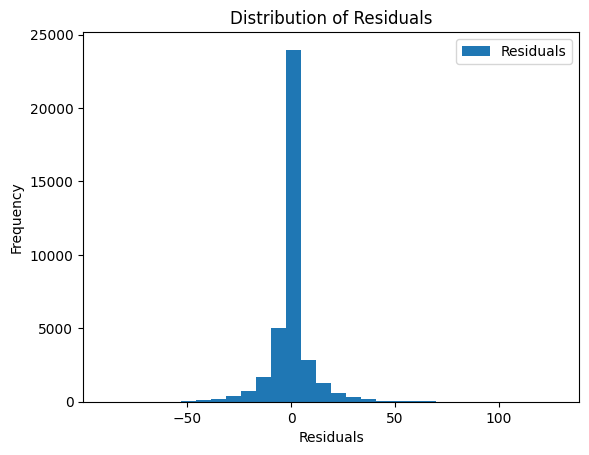

In [41]:
residuals = predictions_rf.withColumn("Residuals", col("Delivery_Time") - col("prediction"))
residuals.select("Residuals").describe().show()

# Plot residuals (requires converting to Pandas)
residuals_pd = residuals.select("Residuals").toPandas()
residuals_pd.plot(kind="hist", bins=30, title="Distribution of Residuals")
plt.xlabel("Residuals")
plt.show()


In [42]:
cv_metrics = cv_model_rf.avgMetrics
print(f"Cross-Validation Metrics (Average RMSE for each parameter setting): {cv_metrics}")


Cross-Validation Metrics (Average RMSE for each parameter setting): [np.float64(27.794090008398978), np.float64(21.01401328675936), np.float64(10.359638004633325), np.float64(27.446859292642), np.float64(20.65374419965854), np.float64(9.894609687090925), np.float64(27.323708594926728), np.float64(20.701530638064312), np.float64(9.84390078316547)]


25/01/23 17:08:50 WARN TaskSetManager: Stage 77394 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.


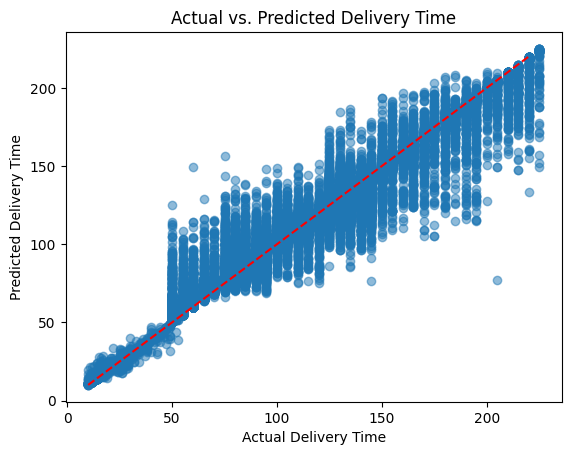

In [43]:
predictions_pd = predictions_rf.select("Delivery_Time", "prediction").toPandas()
plt.scatter(predictions_pd["Delivery_Time"], predictions_pd["prediction"], alpha=0.5)
plt.plot([10, 220], [10, 220], color='red', linestyle='--')  # Line y=x
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.title("Actual vs. Predicted Delivery Time")
plt.show()


25/01/23 17:09:46 WARN TaskSetManager: Stage 77395 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:09:47 WARN TaskSetManager: Stage 77396 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:09:48 WARN TaskSetManager: Stage 77397 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:09:49 WARN TaskSetManager: Stage 77399 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:09:51 WARN TaskSetManager: Stage 77401 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:09:51 WARN TaskSetManager: Stage 77403 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.
25/01/23 17:09:51 WARN TaskSetManager: Stage 77405 contains a task of very large size (5580 KiB). The maximum recommended task siz

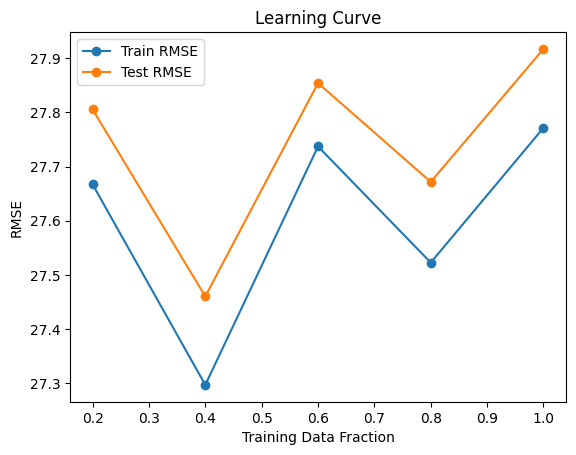

In [44]:
import matplotlib.pyplot as plt
fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
train_rmse = []
test_rmse = []

for frac in fractions:
    sampled_train_data = train_data.sample(withReplacement=False, fraction=frac, seed=42)
    rf_model = rf.fit(sampled_train_data)
    train_rmse.append(evaluator.evaluate(rf_model.transform(sampled_train_data)))
    test_rmse.append(evaluator.evaluate(rf_model.transform(test_data)))

plt.plot(fractions, train_rmse, label="Train RMSE", marker="o")
plt.plot(fractions, test_rmse, label="Test RMSE", marker="o")
plt.xlabel("Training Data Fraction")
plt.ylabel("RMSE")
plt.title("Learning Curve")
plt.legend()
plt.show()


25/01/23 18:14:36 WARN TaskSetManager: Stage 77485 contains a task of very large size (5580 KiB). The maximum recommended task size is 1000 KiB.


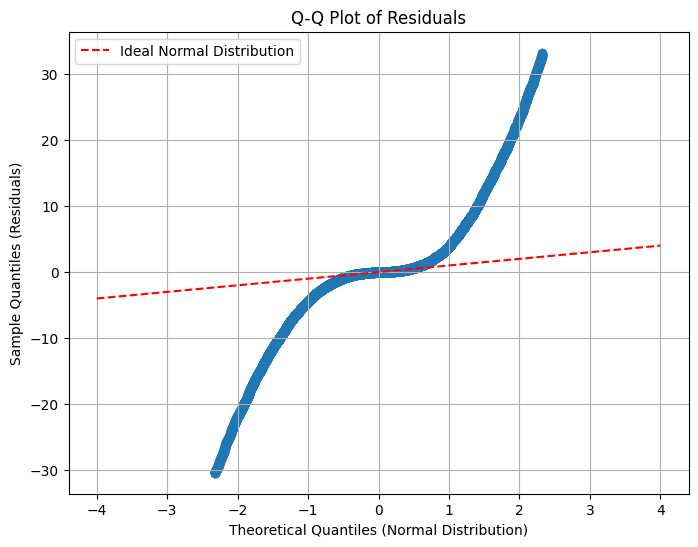

In [47]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Convert residuals to a NumPy array for easier processing with scipy.stats
residuals_np = residuals.select("Residuals").toPandas()['Residuals'].values

# Calculate theoretical quantiles for a normal distribution
theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(residuals_np))) #avoid 0 and 1 for ppf

# Calculate sample quantiles of the residuals
sample_quantiles = np.quantile(residuals_np, np.linspace(0.01, 0.99, len(residuals_np)))

# Create the Q-Q plot
plt.figure(figsize=(8, 6))  # Adjust figure size for better visualization
plt.scatter(theoretical_quantiles, sample_quantiles, alpha=0.5)  # Add alpha for better visualization of overlapping points
plt.plot([-4, 4], [-4, 4], linestyle='--', color='red', label='Ideal Normal Distribution') # Add a reference line
plt.xlabel('Theoretical Quantiles (Normal Distribution)')
plt.ylabel('Sample Quantiles (Residuals)')
plt.title('Q-Q Plot of Residuals')
plt.grid(True)
plt.legend()
plt.show()

In [49]:
predictions_pd.to_csv("predictions_rf.csv", index=False)


In [52]:
data = {
    "Fraction": fractions,
    "Train_RMSE": train_rmse,
    "Test_RMSE": test_rmse
}
print(data)
# learning_df = pd.DataFrame(data)

# # Save the DataFrame as a CSV file
# learning_df.to_csv("rmse_vs_fraction.csv", index=False)

{'Fraction': [0.2, 0.4, 0.6, 0.8, 1.0], 'Train_RMSE': [27.667063546017335, 27.29710656529038, 27.737009606001358, 27.522724610396576, 27.771373730456215], 'Test_RMSE': [27.805366868438647, 27.460433752805557, 27.853888432619293, 27.67154717744196, 27.91688426956803]}


25/01/24 02:04:52 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 933226 ms exceeds timeout 120000 ms
25/01/24 02:04:52 WARN SparkContext: Killing executors is not supported by current scheduler.
25/01/24 02:04:54 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

ConnectionRefusedError: [Errno 61] Connection refused

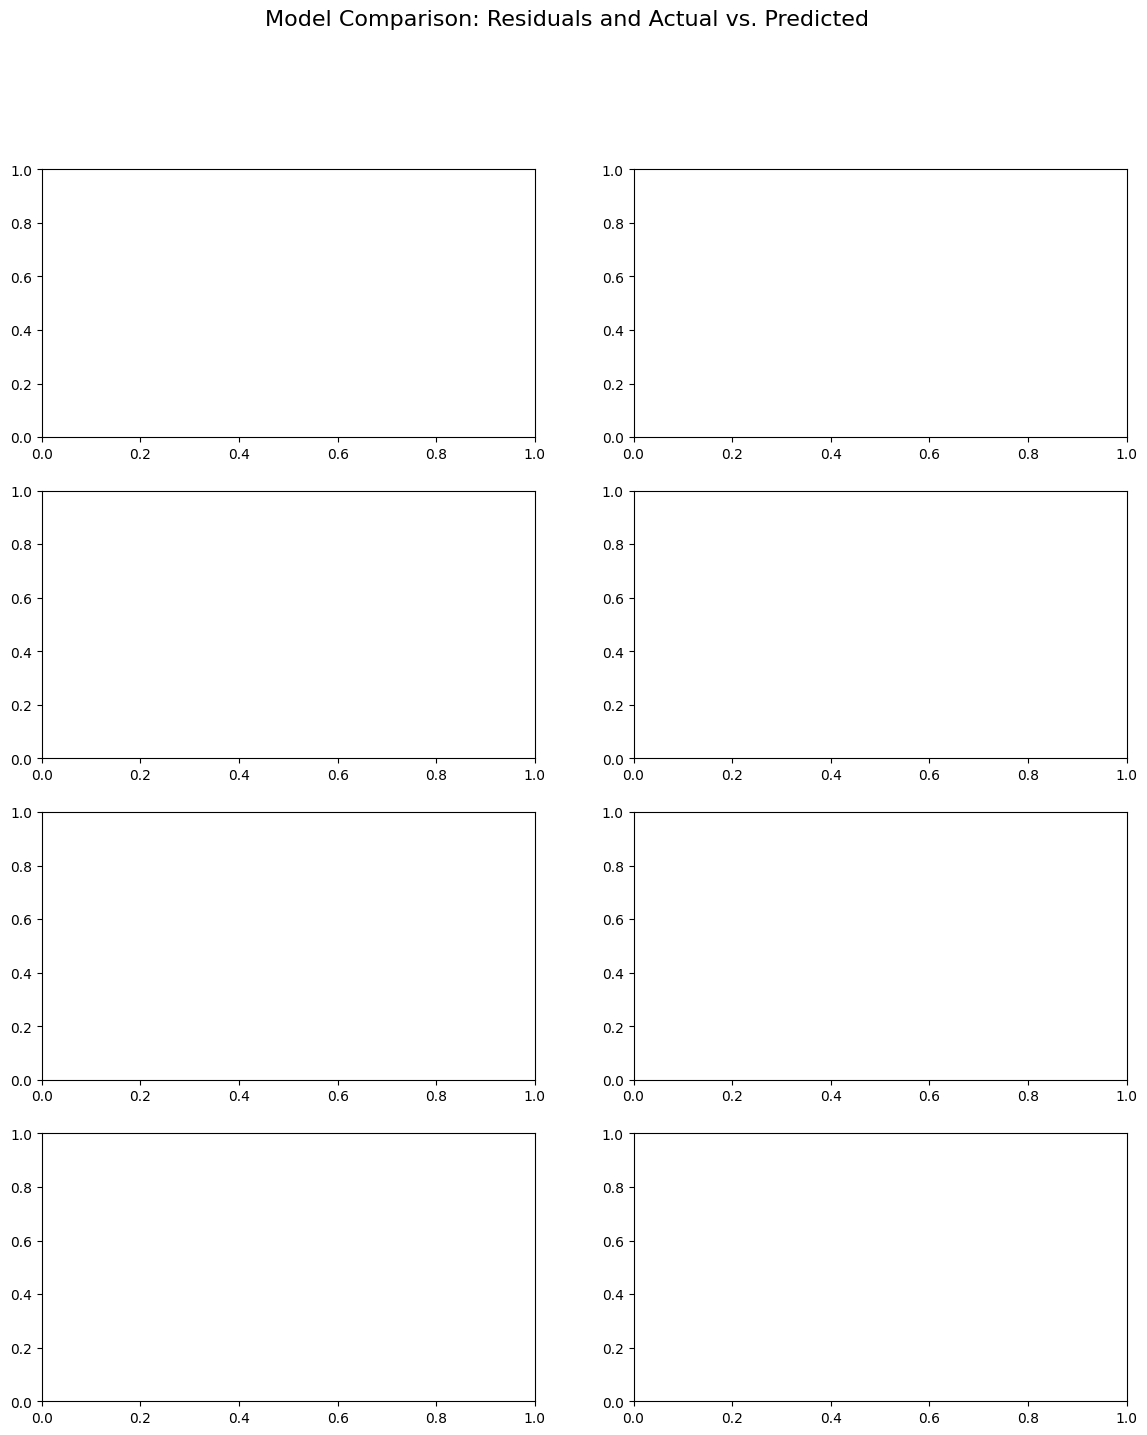

In [54]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Define a dictionary to store model predictions for easier iteration
model_predictions = {
    "Linear Regression": predictions_lr,
    "Decision Tree Regressor": predictions_dtr,
    "Random Forest Regressor": predictions_rf,
    "Gradient-Boosted Trees (GBT)": predictions_gbt,
}

# Create a figure with subplots for residuals and actual vs. predicted plots
fig, axes = plt.subplots(len(model_predictions), 2, figsize=(14, len(model_predictions) * 4))
fig.suptitle("Model Comparison: Residuals and Actual vs. Predicted", fontsize=16)

# Loop through each model's predictions to compute and plot
for i, (model_name, predictions) in enumerate(model_predictions.items()):
    # Calculate residuals
    residuals = predictions.withColumn("Residuals", col("Delivery_Time") - col("prediction"))
    residuals_pd = residuals.select("Residuals").toPandas()
    predictions_pd = predictions.select("Delivery_Time", "prediction").toPandas()
    
    # Residuals Histogram
    axes[i, 0].hist(residuals_pd["Residuals"], bins=30, color="skyblue", edgecolor="black")
    axes[i, 0].set_title(f"Residual Distribution - {model_name}")
    axes[i, 0].set_xlabel("Residuals")
    axes[i, 0].set_ylabel("Frequency")
    
    # Actual vs. Predicted Scatter Plot
    axes[i, 1].scatter(predictions_pd["prediction"], predictions_pd["Delivery_Time"], alpha=0.5, color="orange")
    axes[i, 1].set_title(f"Actual vs. Predicted - {model_name}")
    axes[i, 1].set_xlabel("Predicted Values")
    axes[i, 1].set_ylabel("Actual Values")
    axes[i, 1].grid(True)

# Adjust layout to prevent overlapping text
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
